<a href="https://colab.research.google.com/github/sathwikmarripally/UGR_Research/blob/main/titanic_ugr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Import Libraries and load data.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb

# Load data
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')


<h3>Data Exploration and Initial Visualization</h3>

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

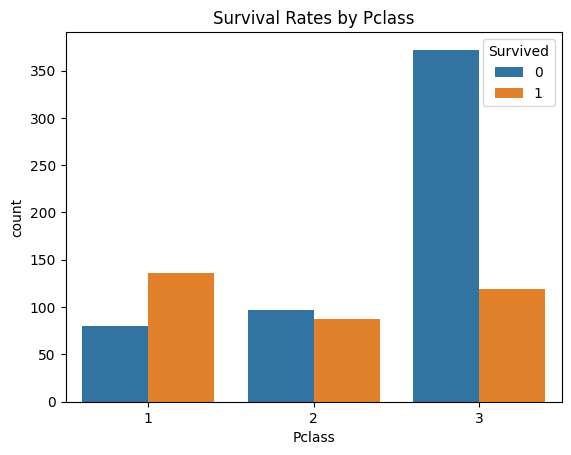

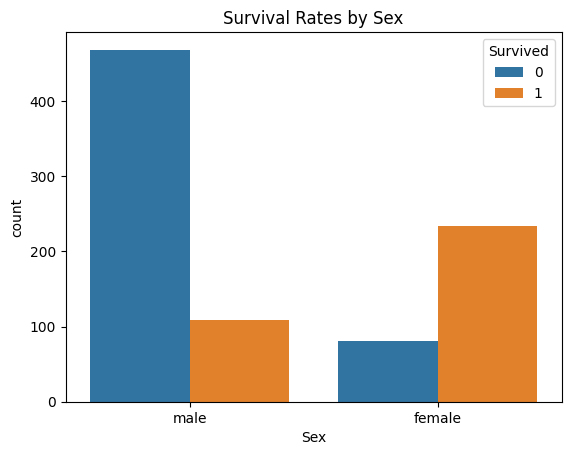

In [15]:
# Quick data overview
print(train_data.head())
print(train_data.info())

# Visualize survival rates based on Pclass and Sex
sns.countplot(data=train_data, x='Pclass', hue='Survived')
plt.title('Survival Rates by Pclass')
plt.show()

sns.countplot(data=train_data, x='Sex', hue='Survived')
plt.title('Survival Rates by Sex')
plt.show()


<h3>Fill Missing Values </h3>

In [16]:
# Fill missing 'Age' based on the median, grouped by 'Pclass' and 'Sex'
train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
test_data['Age'] = test_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Fill missing 'Embarked' with the mode
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

# Fill missing 'Fare' in the test set with the median
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())


<h3>Feature Engineering</h3>

In [17]:
# Create 'FamilySize' feature
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

# Create 'IsAlone' feature
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

# Create 'HasCabin' feature
train_data['HasCabin'] = train_data['Cabin'].notnull().astype(int)
test_data['HasCabin'] = test_data['Cabin'].notnull().astype(int)

# Extract 'Title' from 'Name' and simplify
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_data['Title'] = train_data['Title'].replace(
    ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare'
)
test_data['Title'] = test_data['Title'].replace(
    ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare'
)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train_data['Title'] = train_data['Title'].map(title_mapping).fillna(0)
test_data['Title'] = test_data['Title'].map(title_mapping).fillna(0)


<h3>Encode Categorical Variables </h3>

In [18]:
# Encode 'Sex' and 'Embarked'
label_encoder = LabelEncoder()
train_data['Sex'] = label_encoder.fit_transform(train_data['Sex'])
test_data['Sex'] = label_encoder.transform(test_data['Sex'])

train_data['Embarked'] = label_encoder.fit_transform(train_data['Embarked'])
test_data['Embarked'] = label_encoder.transform(test_data['Embarked'])


<h3> Prepare Features and Labels</h3>

In [19]:
# Defining features for the model
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'HasCabin', 'Title']
X_train = train_data[features]
y_train = train_data['Survived']
X_test = test_data[features]


<h3>Split Training Data for Validation</h3>

In [20]:
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


<h3>Train XGBoost Model</h3>

In [21]:
# Set up and train the XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model.fit(X_train_part, y_train_part)

# Make predictions on the validation set
y_val_pred = xgb_model.predict(X_val)


<h3>Evaluate Model Performance</h3>

Validation Accuracy: 0.8268


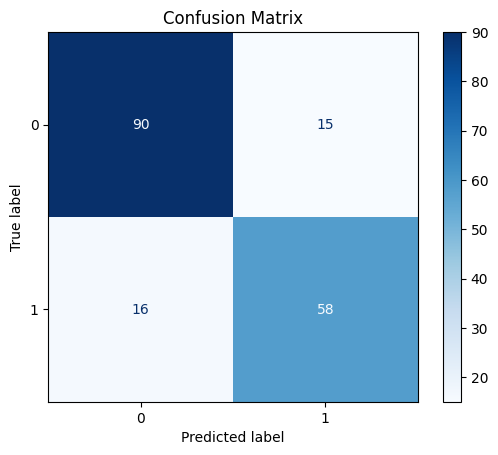

Misclassification Rate: 0.1732


In [22]:
# Calculate classification accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Calculate and display misclassification rate
misclassification_rate = 1 - val_accuracy
print(f'Misclassification Rate: {misclassification_rate:.4f}')


<h3>Generate Submission File</h3>

In [23]:
# Predict on the test set
y_test_pred = xgb_model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': y_test_pred
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file generated: submission.csv")


Submission file generated: submission.csv
